In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import h5py

from plot import PlotAx, STYLE_PATH
from util import rad2tbb

%matplotlib inline

/home/cali/bin/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


### 加载训练数据

X：测量通道radiance

Y：预测通道radiance

In [2]:
in_dir = '/home/cali/data/GapFilling/CRISFull/'
filenames = os.listdir(in_dir)
in_files = [os.path.join(in_dir, filename) for filename in filenames]
in_files.sort()

# ranges_X = [(650., 1095.), (1210., 1750.), (2155., 2550.), ]
ranges_X = [(650., 1095), ]
# ranges_X = [(1210., 1750), ]
# ranges_X = [(2155., 2550.), ]

# ranges_Y = [(1095.625, 1209.375), (1750.625, 2154.375), (2550.625, 2755.), ]
ranges_Y = [(1095.625, 1209.375), ]
# ranges_Y = [(1750.625, 2154.375), ]
# ranges_Y = [(2550., 2755.), ]

In [3]:
from util import get_cris_full_train_data, get_range_index
X, Y = get_cris_full_train_data(in_files, x_ranges=ranges_X, y_ranges=ranges_Y, count=200000)

XY = pd.concat([X, Y], axis=1)
XY = XY.astype('float32')
print(XY.shape)
XY[XY <= 0] = np.nan
XY = XY.dropna(axis=0)
print(XY.shape)
X_col = X.shape[1]
Y_col = Y.shape[1]
X = XY.iloc[:, :X_col]
Y = XY.iloc[:, X_col: X_col+Y_col]

(200000, 896)
(199785, 896)


In [4]:
# 制作绘图用的X轴数据
wavenumber_X = []
for s, e in ranges_X:
    wavenumber_X = np.append(wavenumber_X, np.arange(s, e + 0.625, 0.625))

wavenumber_Y = []
for s, e in ranges_Y:
    wavenumber_Y = np.append(wavenumber_Y, np.arange(s, e + 0.625, 0.625))

# 制作绘图用的切分X轴数据的index
from util import get_range_index
index_X = get_range_index(ranges_X, step=0.625)
index_Y = get_range_index(ranges_Y, step=0.625)
print(index_X)
print(index_Y)

[[0, 713]]
[[0, 183]]


In [5]:
# X.describe()

In [6]:
# Y.describe()

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199785 entries, 0 to 199999
Columns: 713 entries, 0 to 712
dtypes: float32(713)
memory usage: 544.9 MB


In [8]:
Y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199785 entries, 0 to 199999
Columns: 183 entries, 0 to 182
dtypes: float32(183)
memory usage: 141.0 MB


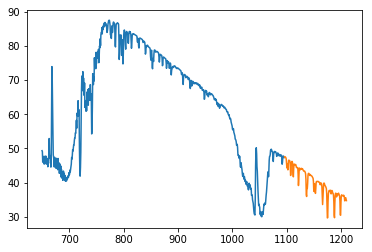

In [9]:
mean_X = X.mean()
for s, e in index_X:
    plt.plot(wavenumber_X[s:e], mean_X.iloc[s:e])

mean_Y = Y.mean()
for s, e in index_Y:
    plt.plot(wavenumber_Y[s:e], mean_Y.iloc[s:e])

In [10]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, random_state = 42, test_size=0.2)

### 使用线性回归训练

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

lin_reg = LinearRegression(normalize=False)
lin_reg.fit(train_X, train_Y)

val_predictions = lin_reg.predict(test_X)

print(mean_absolute_error(test_Y, val_predictions))
print(mean_squared_error(test_Y, val_predictions))

0.15209377
0.039482832


In [12]:
wavenumber_Y = []
for s, e in ranges_Y:
    wavenumber_Y = np.append(wavenumber_Y, np.arange(s, e + 0.625, 0.625))

test_rad = np.array(test_Y)
test_tbb = rad2tbb(test_rad, wavenumber_Y)

prediction_rad = lin_reg.predict(test_X)
prediction_tbb = rad2tbb(prediction_rad, wavenumber_Y)

bias_tbb = prediction_tbb - test_tbb

In [13]:
test_rad = np.array(test_Y)
test_tbb = rad2tbb(test_rad, wavenumber_Y)

In [14]:
prediction_rad = lin_reg.predict(test_X)
prediction_tbb = rad2tbb(prediction_rad, wavenumber_Y)

In [15]:
idx = np.where(prediction_rad<=0)
print(idx[0].shape)

(0,)


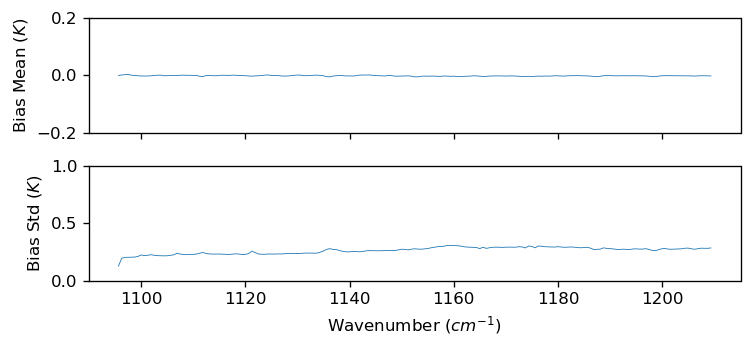

In [16]:
fig = plt.figure(figsize=(6.4, 3), dpi=120)
ax1 = plt.subplot2grid((2, 1), (0, 0))
ax2 = plt.subplot2grid((2, 1), (1, 0), sharex=ax1)

for s, d in index_Y:
    ax1.plot(wavenumber_Y[s:d], bias_tbb.mean(axis=0)[s:d], lw=0.5)
    ax1.set_ylim(-0.2, 0.2)
    ax1.set_ylabel('Bias Mean $(K)$')
    ax2.plot(wavenumber_Y[s:d], bias_tbb.std(axis=0)[s:d], lw=0.5)
    ax2.set_ylim(0.0, 1)
    ax2.set_xlabel('Wavenumber $(cm^{-1})$')
    ax2.set_ylabel('Bias Std $(K)$')

plt.setp(ax1.get_xticklabels(), visible=False)
plt.tight_layout()

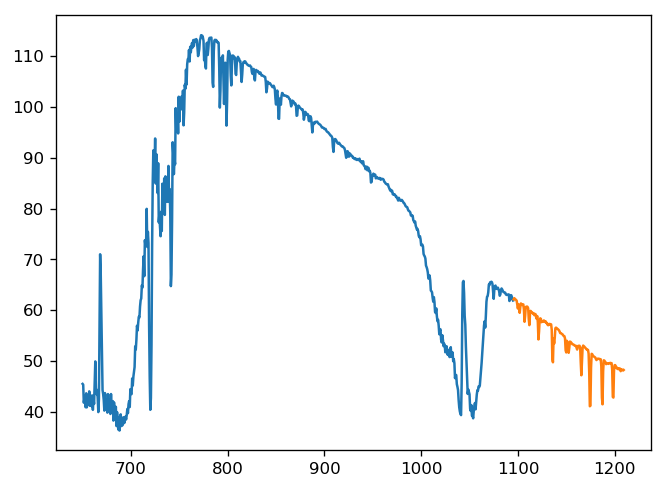

In [17]:
fig_size = (6.4, 4.8)
plt.figure(figsize=fig_size, dpi=120)
for s, e in index_X:
    plt.plot(wavenumber_X[s:e], test_X.iloc[0, s:e])


for s, e in index_Y:
    plt.plot(wavenumber_Y[s:e], val_predictions[0, s:e])

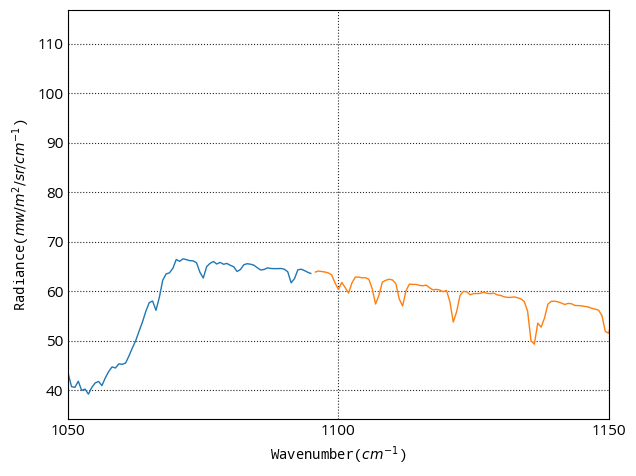

In [18]:
format_kwargs = {
        'x_axis_min': 500,
        'x_axis_max': 3000,
        'x_interval': 500,
        'x_label': 'Wavenumber($cm^{-1}$)',

#         'y_axis_min': 0,
#         'y_axis_max': 120,
#         'y_interval': 30,
        'y_label': 'Radiance($mw/m^2/sr/cm^{-1}$)'

    }

format_kwargs = {
        'x_axis_min': 1050,
        'x_axis_max': 1150,
        'x_interval': 50,
        'x_label': 'Wavenumber($cm^{-1}$)',

#         'y_axis_min': 60,
#         'y_axis_max': 80,
#         'y_interval': 5,
        'y_label': 'Radiance($mw/m^2/sr/cm^{-1}$)'

    }

# format_kwargs = {
#         'x_axis_min': 1150,
#         'x_axis_max': 1250,
#         'x_interval': 50,
#         'x_label': 'Wavenumber($cm^{-1}$)',

# #         'y_axis_min': 40,
# #         'y_axis_max': 60,
# #         'y_interval': 5,
#         'y_label': 'Radiance($mw/m^2/sr/cm^{-1}$)'

#     }

# format_kwargs = {
#         'x_axis_min': 1700,
#         'x_axis_max': 1800,
#         'x_interval': 50,
#         'x_label': 'Wavenumber($cm^{-1}$)',

# #         'y_axis_min': 0,
# #         'y_axis_max': 10,
# #         'y_interval': 5,
#         'y_label': 'Radiance($mw/m^2/sr/cm^{-1}$)'

#     }

# format_kwargs = {
#         'x_axis_min': 2100,
#         'x_axis_max': 2200,
#         'x_interval': 50,
#         'x_label': 'Wavenumber($cm^{-1}$)',

# #         'y_axis_min': 0,
# #         'y_axis_max': 10,
# #         'y_interval': 5,
#         'y_label': 'Radiance($mw/m^2/sr/cm^{-1}$)'

#     }

# format_kwargs = {
#         'x_axis_min': 2500,
#         'x_axis_max': 2800,
#         'x_interval': 50,
#         'x_label': 'Wavenumber($cm^{-1}$)',

#         'y_axis_min': 0,
#         'y_axis_max': 1,
#         'y_interval': 5,
#         'y_label': 'Radiance($mw/m^2/sr/cm^{-1}$)'

#     }

plot_kwargs = {
    'lw': 1
}

out_file = 'pic/cris_gap_filling.png'

if format_kwargs is None:
    format_kwargs = {}
style_path = STYLE_PATH
style_file = os.path.join(style_path, 'plot_regression.mplstyle')
plt.style.use(style_file)
fig_size = (6.4, 4.8)
dpi = 100
fig = plt.figure(figsize=fig_size, dpi=dpi)

plot_ax = PlotAx()
ax1 = plt.subplot2grid((1, 1), (0, 0))

for s, e in index_X:
    ax1.plot(wavenumber_X[s:e], test_X.iloc[1, s:e], **plot_kwargs)

for s, e in index_Y:
    ax1.plot(wavenumber_Y[s:e], val_predictions[1, s:e], **plot_kwargs)

# ##### 格式化图片
if format_kwargs is None:
    format_kwargs = dict()
plot_ax.format_ax(ax1, **format_kwargs)
plt.tight_layout()
# ##### 保存图片
fig.savefig(out_file, dpi=dpi)
fig.show()